In [32]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings

include("../../telegram/notifications.jl");

In [173]:
T = 150         # final time
k = 3          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.6
h = 0.0;

In [174]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [ ]:
matrix_sizes = [10, 15, 20, 30, 40]
maxiters = fill(70, length(matrix_sizes))
maxiters = [70, 70, 70, 70, 50]
iters = zeros(Int, length(maxiters))
tol = 1e-5
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 2    Time: 0:00:00
  Δ:                0.1646915961599844


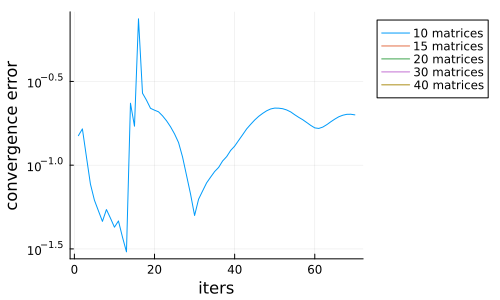

In [185]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300),
    legend=:outertopright)

In [ ]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = only(means(spin, bp));

In [ ]:
m_ss, = equilibrium_observables(RandomRegular(k), J; β, h)

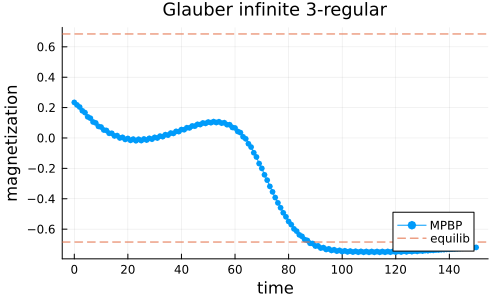

In [183]:
blue = theme_palette(:auto)[1]
pl = plot(0:T, map(spin, only(cb.m[end])), m=:o, xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:20:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
    legend=:bottomright, msc=:auto, c=blue)
hline!(pl, [m_ss, -m_ss], ls=:dash, label="equilib")

In [ ]:
@telegram "glauber infinite"

## Monte Carlo

In [ ]:
using Graphs, IndexedGraphs, Statistics

N = 10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [ ]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = mean(vec(spin.(mean(X, dims=1))) for X in sms.X);

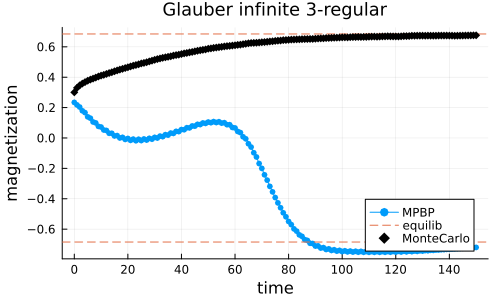

In [184]:
scatter!(deepcopy(pl), 0:T, m_mc, m=:diamond, c=:black, size=(500,300), label="MonteCarlo")